# <b>1 <span style='color:#4285f4'>|</span> Setup</b>

In [43]:
# For ML models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from catboost import CatBoostClassifier as cbc
from sklearn.svm import SVC

#Evalutaion Metrics
from sklearn.metrics import f1_score, plot_confusion_matrix, accuracy_score, classification_report, matthews_corrcoef
from sklearn.model_selection import GridSearchCV

# For Data Processing
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Miscellaneous
import os
import random

# Setup sklearnex to speed up training
# pip install scikit-learn-intelex
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# <b>2 <span style='color:#4285f4'>|</span> About the Dataset</b>

In [11]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
del df['id']
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


## Column Descriptions
- `id`: unique identifier
- `gender`: "Male", "Female" or "Other"
- `age`: age of the patient
- `hypertension`: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
- `heart_disease`: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
- `ever_married`: "No" or "Yes"
- `work_type`: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
- `Residence_type`: "Rural" or "Urban"
- `avg_glucose_level`: average glucose level in blood
- `bmi`: body mass index
- `smoking_status`: "formerly smoked", "never smoked", "smokes" or "Unknown"*
- `stroke`: 1 if the patient had a stroke or 0 if not
*Note: "Unknown" in `smoking_status` means that the information is unavailable for this patient

Categorical Features  
`gender`, `hypertension`, `heart_disease`, `ever_married`, `work_type`, `Residence_type`, `smoking_status`, `stroke`  
Continuous Features  
`age`, `avg_glucose_level`, `bmi`  

I will replace all `0` as `No` and all `1` as `Yes` for now, for visualization purposes in the EDA section of this notebook

In [12]:
for col in ['hypertension', 'heart_disease', 'stroke']:
    df[col] = df[col].apply(lambda x: {0:'No', 1:'Yes'}[x])

## Missing Values Visualization

In [13]:
fig = px.imshow(df.isna().transpose(),color_continuous_scale="Blues")
fig.show()

#### Only `bmi` has *some* missing values. So, to keep things simple, I will delete the rows that contains those missing values.

In [14]:
df = df[df['bmi'].notna()]

## Column Statistics (of numerical data)

In [15]:
df.describe()[1:][['age','avg_glucose_level','bmi']].T.style.background_gradient(cmap='Blues')

,mean,std,min,25%,50%,75%,max
age,42.865374,22.555115,0.080000,25.000000,44.000000,60.000000,82.000000
avg_glucose_level,105.305150,44.424341,55.120000,77.070000,91.680000,113.570000,271.740000
bmi,28.893237,7.854067,10.300000,23.500000,28.100000,33.100000,97.600000


## Column Statistics (of categorical data)

In [16]:
fig = make_subplots(
    rows=4, cols=2, subplot_titles=("gender", "hypertension",
                                    "heart_disease","ever_married",
                                    "work_type", "Residence_type",
                                    'smoking_status', 'stroke'),
    specs=[[{"type": "domain"}, {"type": "domain"}],
           [{"type": "domain"}, {"type": "domain"}],
           [{"type": "domain"}, {"type": "domain"}],
           [{"type": "domain"}, {"type": "domain"}]],
)


colours = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']

fig.add_trace(go.Pie(labels=np.array(df['gender'].value_counts().index),
                     values=[x for x in df['gender'].value_counts()],
                     textinfo='label+percent', rotation=-45, hole=.35,
                     marker_colors=colours),
              row=1, col=1)

fig.add_trace(go.Pie(labels=np.array(df['hypertension'].value_counts().index),
                     values=[x for x in df['hypertension'].value_counts()],
                     textinfo='label+percent', hole=.35,
                     marker_colors=colours),
              row=1, col=2)

fig.add_trace(go.Pie(labels=np.array(df['heart_disease'].value_counts().index),
                     values=[x for x in df['heart_disease'].value_counts()],
                     textinfo='label+percent', rotation=-45, hole=.35,
                     marker_colors=colours),
              row=2, col=1)

fig.add_trace(go.Pie(labels=np.array(df['ever_married'].value_counts().index),
                     values=[x for x in df['ever_married'].value_counts()],
                     textinfo='label+percent', rotation=-45, hole=.35,
                     marker_colors=colours),
              row=2, col=2)

fig.add_trace(go.Pie(labels=np.array(df['work_type'].value_counts().index),
                     values=[x for x in df['work_type'].value_counts()],
                     textinfo='label+percent', hole=.35,
                     marker_colors=colours),
              row=3, col=1)

fig.add_trace(go.Pie(labels=np.array(df['Residence_type'].value_counts().index),
                     values=[x for x in df['Residence_type'].value_counts()],
                     textinfo='label+percent', hole=.35,
                     marker_colors=colours),
              row=3, col=2)

fig.add_trace(go.Pie(labels=np.array(df['smoking_status'].value_counts().index),
                     values=[x for x in df['smoking_status'].value_counts()],
                     textinfo='label+percent', rotation=-45, hole=.35,
                     marker_colors=colours),
              row=4, col=1)

fig.add_trace(go.Pie(labels=np.array(df['stroke'].value_counts().index),
                     values=[x for x in df['stroke'].value_counts()],
                     rotation=-45, textinfo='label+percent', hole=.35,
                     marker_colors=colours),
              row=4, col=2)

fig.update_layout(height=2000, font=dict(size=14), showlegend=False)

fig.show()

# <b>3 <span style='color:#4285f4'>|</span> Exploratory Analysis</b>

<h2>3.1 <span style='color:#4285f4'>|</span> Visualization of Continuous Data</h2>

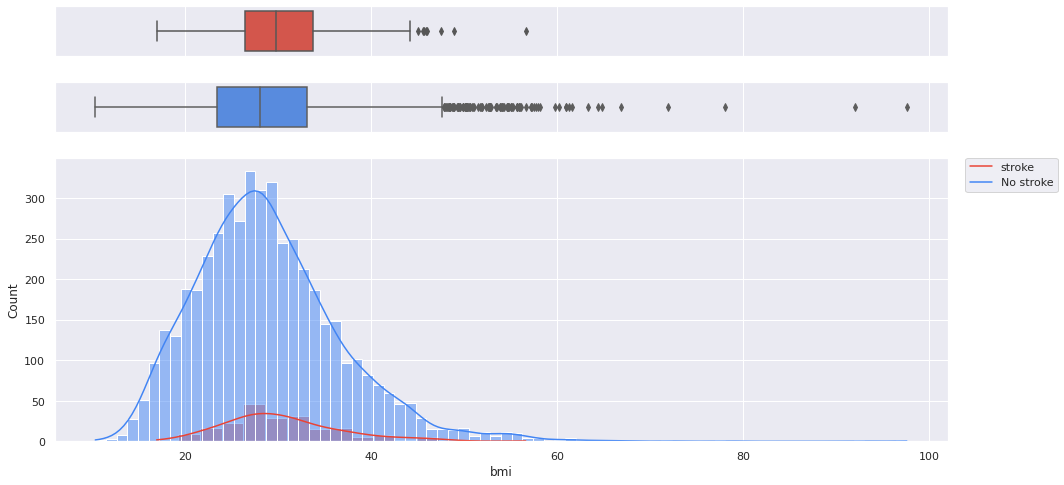

In [17]:
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(16,8)})
 
# creating a figure composed of 3 matplotlib.Axes objects
f, (ax_box1, ax_box2, ax_hist) = plt.subplots(3, sharex=True, gridspec_kw={"height_ratios": (.15, .15, .85)})
# assigning a graph to each ax
sns.boxplot(x=df[df['stroke']=='Yes']["bmi"], ax=ax_box1, color="#ea4335")
sns.histplot(df[df['stroke']=='Yes'], x="bmi", ax=ax_hist, kde=True, color="#ea4335")

sns.boxplot(x=df[df['stroke']=='No']["bmi"], ax=ax_box2, color='#4285f4')
sns.histplot(df[df['stroke']=='No'], x="bmi", ax=ax_hist, kde=True, color='#4285f4')
 
# Remove x axis name for the boxplots
ax_box1.set(xlabel='')
ax_box2.set(xlabel='')

plt.legend(title='', loc=2, labels=['stroke', 'No stroke'],bbox_to_anchor=(1.02, 1), borderaxespad=0.)
plt.show()

### Insights
- People who had a stroke have a slightly higher bmi than those who never had a stroke

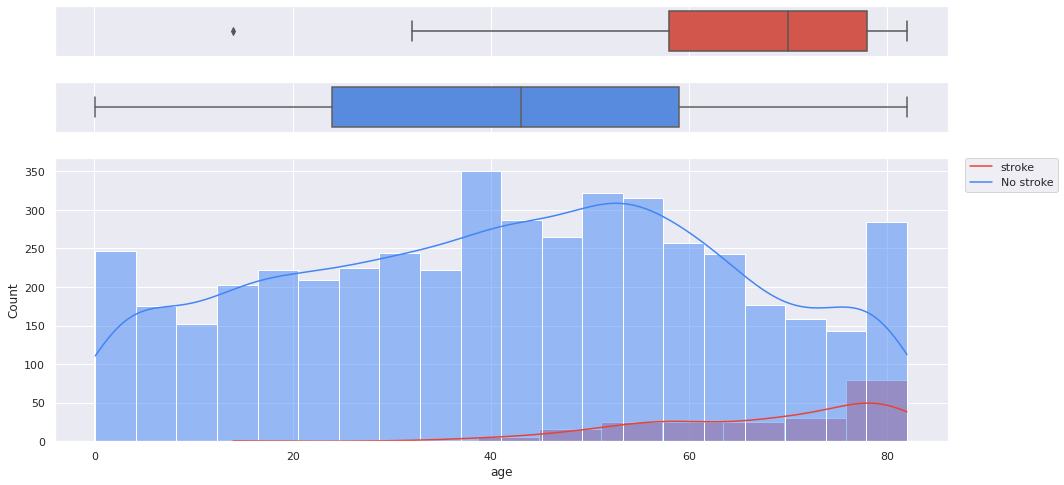

In [18]:
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(16,8)})
 
# creating a figure composed of 3 matplotlib.Axes objects
f, (ax_box1, ax_box2, ax_hist) = plt.subplots(3, sharex=True, gridspec_kw={"height_ratios": (.15, .15, .85)})
# assigning a graph to each ax
sns.boxplot(x=df[df['stroke']=='Yes']["age"], ax=ax_box1, color="#ea4335")
sns.histplot(df[df['stroke']=='Yes'], x="age", ax=ax_hist, kde=True, color="#ea4335")

sns.boxplot(x=df[df['stroke']=='No']["age"], ax=ax_box2, color='#4285f4')
sns.histplot(df[df['stroke']=='No'], x="age", ax=ax_hist, kde=True, color='#4285f4')
 
# Remove x axis name for the boxplots
ax_box1.set(xlabel='')
ax_box2.set(xlabel='')

plt.legend(title='', loc=2, labels=['stroke', 'No stroke'],bbox_to_anchor=(1.02, 1), borderaxespad=0.)
plt.show()

### Insights
- Most people having a stroke are old people

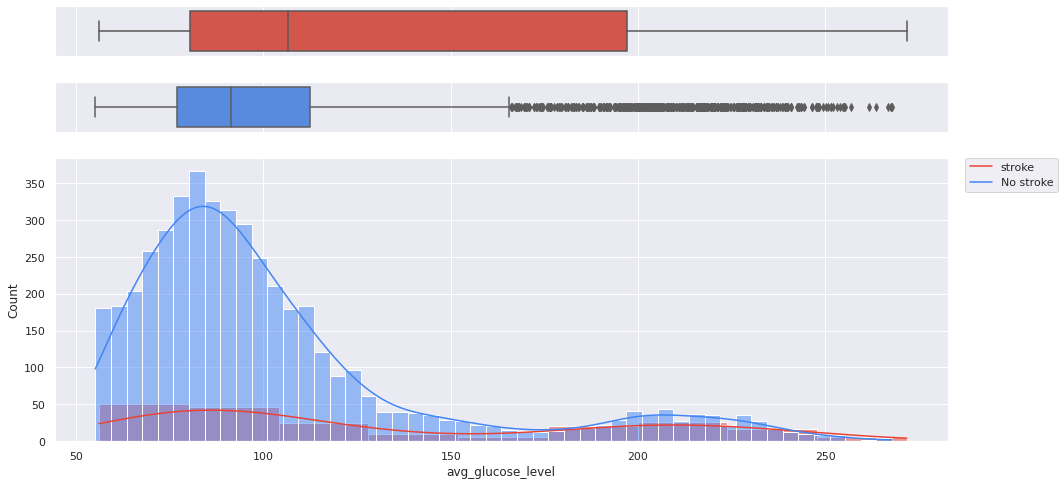

In [19]:
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(16,8)})
 
# creating a figure composed of 3 matplotlib.Axes objects
f, (ax_box1, ax_box2, ax_hist) = plt.subplots(3, sharex=True, gridspec_kw={"height_ratios": (.15, .15, .85)})
# assigning a graph to each ax
sns.boxplot(x=df[df['stroke']=='Yes']["avg_glucose_level"], ax=ax_box1, color="#ea4335")
sns.histplot(df[df['stroke']=='Yes'], x="avg_glucose_level", ax=ax_hist, kde=True, color="#ea4335")

sns.boxplot(x=df[df['stroke']=='No']["avg_glucose_level"], ax=ax_box2, color='#4285f4')
sns.histplot(df[df['stroke']=='No'], x="avg_glucose_level", ax=ax_hist, kde=True, color='#4285f4')
 
# Remove x axis name for the boxplots
ax_box1.set(xlabel='')
ax_box2.set(xlabel='')

plt.legend(title='', loc=2, labels=['stroke', 'No stroke'],bbox_to_anchor=(1.02, 1), borderaxespad=0.)
plt.show()

### Insights
- Most people having a stroke usually have a higher Average glucose level than those who never had a stroke

<h2>3.2 <span style='color:#4285f4'>|</span> Visualization of Categorical Data</h2>

In [20]:
fig = px.histogram(df, x="gender", color='stroke', color_discrete_map = {'Yes':'#ea4335','No':'#4285f4'})
fig.show()

### Insights
- 141 Females had a stroke, and 108 males had a stroke
- It cannot be concluded that Females get more strokes than Males because the number of Females tested in this dataset is much higher than the number of Males tested

In [21]:
fig = px.histogram(df, x="hypertension", color='stroke', color_discrete_map = {'Yes':'#ea4335','No':'#4285f4'})
fig.show()

### Insights
- The number of people who has hypertension is much lower than the number of people who do not
- The proportion of people who had a stroke in the `hypertension` category is much higher than the proportion of people who had a stroke in the `No hypertension` category
- But the number of people who had hypertension is significantly lower than the number of people who didn't, so it cannot be confidently concluded that people with hypertension is more likely to suffer from a stroke than people with no hypertension

In [22]:
fig = px.histogram(df, x="heart_disease", color='stroke', color_discrete_map = {'Yes':'#ea4335','No':'#4285f4'})
fig.show()

### Insights
- The number of people who had heart disease is much lower than the number of people who did not
- The proportion of people who had a stroke in the `heart_disease` category is much higher than the proportion of people who had a stroke in the `No heart_disease` category
- But the number of people who had heart disease is significantly lower than the number of people who didn't, so it cannot be confidently concluded that people with heart disease is more likely to suffer from a stroke than people with no heart disease

In [23]:
fig = px.histogram(df, x="ever_married", color='stroke', color_discrete_map = {'Yes':'#ea4335','No':'#4285f4'})
fig.show()

### Insights
- Most people who had a stroke are married

In [24]:
fig = px.histogram(df, x="work_type", color='stroke', color_discrete_map = {'Yes':'#ea4335','No':'#4285f4'})
fig.show()

### Insights
- Most people who had a stroke work at a private company

In [25]:
fig = px.histogram(df, x="Residence_type", color='stroke', color_discrete_map = {'Yes':'#ea4335','No':'#4285f4'})
fig.show()

### Insights
- The likelihood of having a stroke is the same for living in an urban region and in a rural region

In [26]:
fig = px.histogram(df, x="smoking_status", color='stroke', color_discrete_map = {'Yes':'#ea4335','No':'#4285f4'})
fig.show()

### Insights
- `smoking_status` does not have much influence on the probability of having a stroke

# <b>4 <span style='color:#4285f4'>|</span> Data Cleaning</b>

<h2>4.1 <span style='color:#4285f4'>|</span> Normalizing Continuous Features</h2>  

In [27]:
df.describe()[['age','avg_glucose_level', 'bmi']].T[['min', 'max']].style.background_gradient(cmap='Blues')

,min,max
age,0.080000,82.000000
avg_glucose_level,55.120000,271.740000
bmi,10.300000,97.600000


These continuous have different ranges, so I am normalizing them to be between 0 and 1

In [28]:
for col in ['age', 'avg_glucose_level', 'bmi']:
    df[col] = df[col]/df[col].max()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<h2>4.2 <span style='color:#4285f4'>|</span> Encoding Categorical Features</h2>  

In [29]:
print('\nCategorical Columns\n')
df.select_dtypes(include=['O']).nunique()


Categorical Columns



gender            3
hypertension      2
heart_disease     2
ever_married      2
work_type         5
Residence_type    2
smoking_status    4
stroke            2
dtype: int64

Some categorical columns have 2 unique values, and some have more than 2 unique values.  
Here, I will convert the columns with 2 unique values to binary (either 1 or 0)  
And one-hot encode the other categorical columns which has more than 2 unique values  

In [30]:
# Integer encode columns with 2 unique values
for col in ['hypertension', 'heart_disease', 'ever_married', 'Residence_type', 'stroke']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
# One-hot encode columns with more than 2 unique values
df = pd.get_dummies(df, columns=['gender', 'work_type', 'smoking_status'], prefix = ['gender', 'work_type', 'smoking_status'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<h2>4.3 <span style='color:#4285f4'>|</span> Train-Val Split</h2>  

In [31]:
features = np.array(df[[col for col in df.columns if col!='stroke']])
labels = np.array(df['stroke'])

x_train, x_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=0)

# <b>5 <span style='color:#4285f4'>|</span> Models</b>

In [32]:
model_comparison = {}

<h2>5.1 <span style='color:#4285f4'>|</span> SVC</h2>  

In [44]:
parameters = {'C': [1,2,3,4,5,6], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

svc_model = SVC()

clf = GridSearchCV(svc_model, parameters)
print("Searching for best hyperparameters ...")
clf.fit(x_train, y_train)
print(f'Best Hyperparameters: {clf.best_params_}')

y_pred = clf.predict(x_val)
model_comparison['SVC'] = [accuracy_score(y_val, y_pred), f1_score(y_val, y_pred, average='weighted'), matthews_corrcoef(y_val, y_pred)]
print('\n')
print(classification_report(y_val, y_pred, zero_division=1, digits=3))

Searching for best hyperparameters ...
Best Hyperparameters: {'C': 1, 'kernel': 'linear'}


              precision    recall  f1-score   support

           0      0.956     1.000     0.978       939
           1      1.000     0.000     0.000        43

    accuracy                          0.956       982
   macro avg      0.978     0.500     0.489       982
weighted avg      0.958     0.956     0.935       982



<h2>5.2 <span style='color:#4285f4'>|</span> DecisionTreeClassifier</h2>  

In [45]:
parameters = {'max_depth': [1,2,3,4,5,6]}

Tree_model = DecisionTreeClassifier()

clf = GridSearchCV(Tree_model, parameters)
print("Searching for best hyperparameters ...")
clf.fit(x_train, y_train)
print(f'Best Hyperparameters: {clf.best_params_}')

y_pred = clf.predict(x_val)
model_comparison['DecisionTreeClassifier'] = [accuracy_score(y_val, y_pred), f1_score(y_val, y_pred, average='weighted'), matthews_corrcoef(y_val, y_pred)]
print('\n')
print(classification_report(y_val, y_pred, zero_division=1, digits=3))

Searching for best hyperparameters ...
Best Hyperparameters: {'max_depth': 1}


              precision    recall  f1-score   support

           0      0.956     1.000     0.978       939
           1      1.000     0.000     0.000        43

    accuracy                          0.956       982
   macro avg      0.978     0.500     0.489       982
weighted avg      0.958     0.956     0.935       982



<h2>5.3 <span style='color:#4285f4'>|</span> KNeighborsClassifier</h2>  

In [46]:
parameters = {'n_neighbors': [5,10,15,20]}

K_model = KNeighborsClassifier()

clf = GridSearchCV(K_model, parameters)
print("Searching for best hyperparameters ...")
clf.fit(x_train, y_train)
print(f'Best Hyperparameters: {clf.best_params_}')

y_pred = clf.predict(x_val)
model_comparison['KNeighborsClassifier'] = [accuracy_score(y_val, y_pred), f1_score(y_val, y_pred, average='weighted'), matthews_corrcoef(y_val, y_pred)]
print('\n')
print(classification_report(y_val, y_pred, zero_division=1, digits=3))

Searching for best hyperparameters ...
Best Hyperparameters: {'n_neighbors': 10}


              precision    recall  f1-score   support

           0      0.956     0.999     0.977       939
           1      0.000     0.000     0.000        43

    accuracy                          0.955       982
   macro avg      0.478     0.499     0.489       982
weighted avg      0.914     0.955     0.934       982



<h2>5.4 <span style='color:#4285f4'>|</span> RandomForestClassifier</h2>  

In [47]:
parameters = {'n_estimators': [160, 180, 200, 220], 'max_depth':[16,18,20,22,24]}

rf = RandomForestClassifier()

clf = GridSearchCV(rf, parameters)
print("Searching for best hyperparameters ...")
clf.fit(x_train, y_train)
print(f'Best Hyperparameters: {clf.best_params_}')

y_pred = clf.predict(x_val)
model_comparison['RandomForestClassifier'] = [accuracy_score(y_val, y_pred), f1_score(y_val, y_pred, average='weighted'), matthews_corrcoef(y_val, y_pred)]
print('\n')
print(classification_report(y_val,y_pred, zero_division=1, digits=3))

Searching for best hyperparameters ...
Best Hyperparameters: {'max_depth': 20, 'n_estimators': 160}


              precision    recall  f1-score   support

           0      0.957     1.000     0.978       939
           1      1.000     0.023     0.045        43

    accuracy                          0.957       982
   macro avg      0.979     0.512     0.512       982
weighted avg      0.959     0.957     0.937       982



<h2>5.5 <span style='color:#4285f4'>|</span> XGBoost</h2>  

In [48]:
parameters = {'n_estimators': [80, 100, 120], 'max_depth':[16, 18, 20]}

xgboost = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

clf = GridSearchCV(xgboost, parameters)
print("Searching for best hyperparameters ...")
clf.fit(x_train, y_train)
print(f'Best Hyperparameters: {clf.best_params_}')

y_pred = clf.predict(x_val)
model_comparison['XGBoost'] = [accuracy_score(y_val, y_pred), f1_score(y_val, y_pred, average='weighted'), matthews_corrcoef(y_val, y_pred)]
print('\n')
print(classification_report(y_val, y_pred, zero_division=1, digits=3))

Searching for best hyperparameters ...
Best Hyperparameters: {'max_depth': 20, 'n_estimators': 80}


              precision    recall  f1-score   support

           0      0.958     0.996     0.977       939
           1      0.333     0.047     0.082        43

    accuracy                          0.954       982
   macro avg      0.646     0.521     0.529       982
weighted avg      0.931     0.954     0.937       982



<h2>5.6 <span style='color:#4285f4'>|</span> CatBoost</h2>  

In [50]:
parameters = {'iterations': [80, 100, 120, 200, 400]}

catboost = cbc(logging_level='Silent', eval_metric='AUC')

clf = GridSearchCV(catboost, parameters)
print("Searching for best hyperparameters ...")
clf.fit(x_train, y_train)
print(f'Best Hyperparameters: {clf.best_params_}')

y_pred = clf.predict(x_val)
model_comparison['CatBoost'] = [accuracy_score(y_val, y_pred), f1_score(y_val, y_pred, average='weighted'), matthews_corrcoef(y_val, y_pred)]
print('\n')
print(classification_report(y_val, y_pred, zero_division=1, digits=3))

Searching for best hyperparameters ...
Best Hyperparameters: {'iterations': 100}


              precision    recall  f1-score   support

           0      0.956     1.000     0.978       939
           1      1.000     0.000     0.000        43

    accuracy                          0.956       982
   macro avg      0.978     0.500     0.489       982
weighted avg      0.958     0.956     0.935       982



<h2>5.6 <span style='color:#4285f4'>|</span> Model Comparison</h2>  

In [52]:
model_comparison_df = pd.DataFrame.from_dict(model_comparison).T
model_comparison_df.columns = ['Accuracy', 'F1 Score', 'MCC']
model_comparison_df = model_comparison_df.sort_values('F1 Score', ascending=True)
model_comparison_df.style.background_gradient(cmap='Blues')

,Accuracy,F1 Score,MCC
KNeighborsClassifier,0.955193,0.934299,-0.006832
SVC,0.956212,0.934808,0.000000
DecisionTreeClassifier,0.956212,0.934808,0.000000
CatBoost,0.956212,0.934808,0.000000
RandomForestClassifier,0.957230,0.937285,0.149198
XGBoost,0.954175,0.937317,0.110946


In [53]:
fig = go.Figure(data=[
    go.Bar(name='F1 Score', y=model_comparison_df.index, x=model_comparison_df['F1 Score'], orientation='h', marker_color='#4285f4'),
    go.Bar(name='Accuracy', y=model_comparison_df.index, x=model_comparison_df['Accuracy'], orientation='h', marker_color='#7baaf7')
])
fig.update_layout(barmode='group')
fig.show()